In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import Simulation
from skimage.registration import phase_cross_correlation
import copy
import os

from mbptycho.code.simulation import reloadSimulation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base_path = os.environ['HOME']

In [4]:
probes_3d_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes_4_peaks.mat'

In [5]:
strain_type = 'point_inclusion'

In [293]:
sm = Simulation(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':2,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.4]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_delta_x':5,
                                               'npix_delta_y':5})

Creating new sample...
Depth of numerical window covers 0.5844363636363636 microns
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...


In [320]:
class MultiReflectionBraggPtychoFwdModel:

    
    def __init__(self, sim: Simulation):
        self._sim = sim
        self.variables = {}

        self._setPixelsAndPads()
        with tf.device('/gpu:0'):
            self._coords_t = tf.constant(self._sim.simulations_per_peak[0].nw_coords_stacked, dtype='float32')
            self._setScanCoords()

            self._setInterpolationLimits()
            self._setProbesAndMasks()
            self._setLocationIndices()
            self._setSliceIndices()


    def _setPixelsAndPads(self):
        self._npix_y = np.sum(np.sum(self._sim.sample.obj_mask_w_delta, axis=(1, 2)) > 0)
        self._npix_x = np.sum(np.sum(self._sim.sample.obj_mask_w_delta, axis=(0, 2)) > 0)
        self._npix_z = np.sum(np.sum(self._sim.sample.obj_mask_w_delta, axis=(0, 1)) > 0)

        self._npix_xy = self._npix_x * self._npix_y

        self._nyr, self._nxr, self._nzr = self._sim.rhos[0].shape
        self._pady0 = np.where(self._sim.sample.obj_mask_w_delta.sum(axis=(1, 2)))[0][0]
        self._padx0 = np.where(self._sim.sample.obj_mask_w_delta.sum(axis=(0, 2)))[0][0]
        self._padz0 = np.where(self._sim.sample.obj_mask_w_delta.sum(axis=(0, 1)))[0][0]
        
        self._npix_det = self._sim.params.npix_det
        # projection slice based on number of pixels in the detector
        npix_diffy = (self._nyr - self._npix_det) // 2
        npix_diffx = (self._nxr - self._npix_det) // 2
        self._proj_slice = np.s_[npix_diffy: self._nyr - npix_diffy, npix_diffx: self._nxr - npix_diffx]
    
    def _setScanCoords(self):

        if hasattr(self._sim.simulations_per_peak[0], "ptycho_scan_positions"):
            self._has_scan_coords_per_peak = True
            self._n_positions_per_peak = [s.ptycho_scan_positions.shape[0] for s in self._sim.simulations_per_peak]
            self._cum_positions_per_peak = tf.math.cumsum(self._n_positions_per_peak)
            self._scan_coords_t = tf.constant(np.concatenate([s.ptycho_scan_positions
                                                              for s in self._sim.simulations_per_peak],
                                                             axis=0),
                                              dtype='int32')
        else:
            raise NotImplementedError
            self._has_scan_coords_per_peak = False
            self._scan_coords_t = tf.constant(self._sim.ptycho_scan_positions, dtype='int32')
    
    def _addMagnitudeVariable(self, magnitudes_init=None, magnitude_log_constraint_fn=None):
        if self._shared_magnitudes:
            size = self._npix_xy + self._sim.params.HKL_list.shape[0] - 1
        else:
            size = self._npix_xy * self._sim.params.HKL_list.shape[0]

        if magnitudes_init is None:
            magnitudes_init = np.zeros(size, dtype='float32')
        else:
            if magnitudes_init.size != size:
                raise ValueError("magnitude initialization supplied is not valid")

        magnitudes_init_logs = np.log(magnitudes_init + 1e-7)
        #magnitudes_init_logs = magnitudes_init
        with tf.device('/gpu:0'):
            self.magnitudes_log_v = tf.Variable(magnitudes_init_logs,
                                           constraint=magnitude_log_constraint_fn,
                                           dtype='float32',
                                           name='magnitudes_log_v')
        self.variables['magnitudes_log_v'] =  self.magnitudes_log_v
        
    def _addDisplacementVariable(self, ux_uy_init=None):
        if ux_uy_init is None:
            ux_uy_init = np.ones(self._npix_xy * 2)
        else:
            if len(ux_uy_init.shape) != 1:
                raise ValueError("Supply a flat 1d array for the initialization.")
        with tf.device('/gpu:0'):
            self.ux_uy_2d_v = tf.Variable(ux_uy_init, dtype='float32', name='ux_uy')
        self.variables['ux_uy_2d_v'] = self.ux_uy_2d_v

    def _addPhaseVariable(self, phases_init=None):

        if phases_init is None:
            phases_init = np.zeros(self._npix_xy * self._sim.params.HKL_list.shape[0])

        with tf.device('/gpu:0'):
            self.phases_v = tf.Variable(phases_init, dtype='float32', name='phases')
        self.variables['phases'] = self.phases_v
    
    def _setInterpolationLimits(self):
        # These arrays indicate the limits of the interpolation before the bragg projection.
        self._interp_x_ref_min_t = tf.constant([self._sim.sample.y_full[0],
                                                self._sim.sample.x_full[0],
                                                self._sim.sample.z_full[0]], dtype='float32')
        self._interp_x_ref_max_t = tf.constant([self._sim.sample.y_full[-1],
                                                self._sim.sample.x_full[-1],
                                                self._sim.sample.z_full[-1]], dtype='float32')


    def _setProbesAndMasks(self):

        self.probes_all_t = tf.constant([s.probe for s in self._sim.simulations_per_peak], dtype='complex64')

        # After rotation (for the final projection), we can speed up the interpolation by only selecting
        # the rotated coordinates that lie within the unrotated object box.
        # The number of coordinates to interpolate can vary per bragg peak.
        self._coords_rotated_masked_t = tf.constant(np.concatenate([s.nw_rotated_masked_delta_coords.T.flatten()
                                                                    for s in self._sim.simulations_per_peak]),
                                                    dtype='float32')
        self._rotation_mask_indices_t = tf.constant(np.concatenate([s.nw_rotation_mask_delta_indices.flatten()
                                                                    for s in self._sim.simulations_per_peak]),
                                                    dtype='int32')
    
    def _setLocationIndices(self):
        # These contain information about how to select the appropriate masked coordinates.
        rotix_iloc_all = []
        coords_iloc_all = []
        for i, sim_per_peak in enumerate(self._sim.simulations_per_peak):
            if i == 0:
                s1 = 0
            else:
                s1 = coords_iloc_all[i - 1][0] + coords_iloc_all[i - 1][1]
                s2 = rotix_iloc_all[i - 1][0] + rotix_iloc_all[i - 1][1]
            coords_iloc_all.append([s1, sim_per_peak.nw_rotated_masked_delta_coords.T.size,
                                    *sim_per_peak.nw_rotated_masked_delta_coords.T.shape])
            rotix_iloc_all.append([s1, sim_per_peak.nw_rotation_mask_delta_indices.size,
                                   *sim_per_peak.nw_rotation_mask_delta_indices.shape])
        self._rotix_iloc_t = tf.constant(rotix_iloc_all, dtype='int32')
        self._coords_iloc_t = tf.constant(coords_iloc_all, dtype='int32')

    def _setSliceIndices(self):

        # A lot of this slicing and dicing is aimed at avoiding expensive "roll" operations.
        # I am reusing indices computed during the forward simulation fPor the recons as well.
        #self._scan_probe_pads_t = tf.constant([s.probe_pads for s in self._sim.simulations_per_peak], dtype='int32')
        #self._scan_probe_slice_indices_t = tf.constant([self._getStartStopIndicesFromSliceList(s.probe_slices)
        #                                                for s in self._sim.simulations_per_peak], dtype='int32')
        self._scan_probe_pads = [s.probe_pads for s in self._sim.simulations_per_peak]
        self._scan_probe_slices = [s.probe_slices for s in self._sim.simulations_per_peak]
        
    @staticmethod
    def _getStartStopIndicesFromSliceList(slice_list):
        indices_list = []
        for slice_y, slice_x in slice_list:
            sy1 = slice_y.start
            sy2 = slice_y.stop
            sx1 = slice_x.start
            sx2 = slice_x.stop
            indices_list.append([sy1, sy2, sx1, sx2])
        return indices_list
    
    def _setPhaseDisplacementInversionMatrix(self):
        """To solve an overdetermined linear system Ax = b, we can use the relation:
        x = (A^T A)^(-1) A^T b.

        This function calculates and stores the matrix (A^T A)^(-1) A^T  for the unwrapped phases -> displacement
        transformation.
        """
        hkl_matrix = np.array(self._sim.params.HKL_list)[:, :2]  # Ignoring the z components
        inversion_matrix = np.linalg.inv(hkl_matrix.T @ hkl_matrix) @ hkl_matrix.T / (2 * np.pi)
        self._displacement_invert_matrix_t = tf.constant(inversion_matrix, dtype='float32')
    
    
    def getMagnitudes2d(self, magnitudes_log_v):
        if self._shared_magnitudes:
            mags_log_2d_profile = tf.reshape(magnitudes_log_v[:self._npix_xy], (self._npix_y, self._npix_x))
            mags_scaling_vars = magnitudes_log_v[self._npix_xy:]
            mags_scaling_all = tf.concat(([0.0], mags_scaling_vars), axis=0)
            mags_log_2d_all = mags_log_2d_profile + mags_scaling_all[:, None, None]
        else:
            mags_log_2d_all = tf.reshape(magnitudes_log_v, (-1, self._npix_y, self._npix_x))

        magnitudes_2d_all = tf.exp(mags_log_2d_all)
        #magnitudes_2d_all = mags_log_2d_all
        return magnitudes_2d_all

    def getUxUy2d(self, ux_uy_2d_v):
        ux_uy_2d_reshaped_t = tf.reshape(ux_uy_2d_v, (2, self._npix_y, self._npix_x))
        ux_2d_t = ux_uy_2d_reshaped_t[0]
        uy_2d_t = ux_uy_2d_reshaped_t[1]
        return ux_2d_t, uy_2d_t

    def _get2dPhasesFromDisplacements(self, Ux_t, Uy_t):
        phases_all_t = []
        for H, K, L in self._sim.params.HKL_list:
            t1 = H * Ux_t + K * Uy_t #+ L * Uz_t
            phase_t = 2 * np.pi * t1
            phases_all_t.append(phase_t)
        phases_all_t = tf.stack(phases_all_t)
        return phases_all_t

    def get2dPhasesFromDisplacementVars(self):
        ux_2d_t, uy_2d_t = self.getUxUy2d(self.ux_uy_2d_v)
        uz_2d_t = tf.zeros_like(ux_2d_t)
        phases = self._get2dPhasesFromDisplacements(ux_2d_t, uy_2d_t)
        return phases

    def get2dRhoFromDisplacements(self, Ux_t, Uy_t, magnitudes_2d_t):
        """Calculate the magnitude and phase profile using the provided magnitudes and HKL list.

        Sets the rhos for the sample class, and also returns the rhos.

        Assumes that the displacements are normalized w.r.t. to the lattice constant, i.e.
        Ux_t = Ux_t_actual / lattice[0]
        Uy_t = Uy_t_actual / lattice[1]
        Uz_t = Uz_t actual / lattice[2]

        Parameters
        ----------
        ...
        Returns
        -------
        """

        phases_all_t = self._get2dPhasesFromDisplacements(Ux_t, Uy_t)
        rhos_all_t = tf.complex(magnitudes_2d_t * tf.cos(phases_all_t),
                                magnitudes_2d_t * tf.sin(phases_all_t))
        return rhos_all_t

    def get3dRhoFromDisplacements(self, ux_uy_2d_v, magnitudes_log_v):
        magnitudes_2d_all_t = self.getMagnitudes2d(magnitudes_log_v)

        ux_2d_t, uy_2d_t = self.getUxUy2d(ux_uy_2d_v)
        #uz_2d_t = tf.zeros_like(ux_2d_t)

        rho_2d_cmplx_all_t = self.get2dRhoFromDisplacements(ux_2d_t, uy_2d_t, magnitudes_2d_all_t)
        rho_3d_all_t = tf.ones(self._npix_z, dtype='complex64')[None, None, None, :] * rho_2d_cmplx_all_t[:, :, :, None]
        rho_3d_bordered_all_t = tf.pad(rho_3d_all_t, [[0, 0],
                                                      [self._pady0, self._nyr - self._pady0 - self._npix_y],
                                                      [self._padx0, self._nxr - self._padx0 - self._npix_x],
                                                      [self._padz0, self._nzr - self._padz0 - self._npix_z]])
        return rho_3d_bordered_all_t

    def get2dRhoFromPhases(self, phases_v, magnitudes_log_v):
        magnitudes_2d_all_t = self.getMagnitudes2d(magnitudes_log_v)
        phases_2d_t = tf.reshape(phases_v, [-1, self._npix_y, self._npix_x])
        rho_2d_cmplx_all_t = tf.complex(magnitudes_2d_all_t * tf.math.cos(phases_2d_t),
                                        magnitudes_2d_all_t * tf.math.sin(phases_2d_t))
        return rho_2d_cmplx_all_t

    def get3dRhoFromPhases(self, phases_v, magnitudes_log_v):
        rho_2d_cmplx_all_t = self.get2dRhoFromPhases(phases_v, magnitudes_log_v)
        rho_3d_all_t = tf.ones(self._npix_z, dtype='complex64')[None, None, None, :] * rho_2d_cmplx_all_t[:, :, :, None]
        rho_3d_bordered_all_t = tf.pad(rho_3d_all_t, [[0, 0],
                                                      [self._pady0, self._nyr - self._pady0 - self._npix_y],
                                                      [self._padx0, self._nxr - self._padx0 - self._npix_x],
                                                      [self._padz0, self._nzr - self._padz0 - self._npix_z]])
        return rho_3d_bordered_all_t



    def _getProjFtT(self, rho_3d_bordered_all_t, scan_index):
        """Output the projected diffraction pattern at the input scan index.

        Parameters
        ----------
        scan_index_t : tensor(int)
            This indicates the location of the selected diffraction pattern in the overall
            large array containing all the diffraction patterns, for all the bragg peaks.
        Returns
        -------
        out_t : tensor(float32)
            This is the predicted diffraction pattern.
        """
        #

        # Identifying the appropriate bragg peak and ptychographic scan position for the given
        # scan index
        if self._has_scan_coords_per_peak:
            bragg_index = tf.searchsorted(self._cum_positions_per_peak,
                                          [tf.cast(scan_index, tf.int32)], side='right')[0]
            scan_coord_index = scan_index % self._n_positions_per_peak[0]
        else:
            bragg_index = scan_index // len(self._sim.ptycho_scan_positions)
            scan_coord_index = scan_index % len(self._sim.ptycho_scan_positions)
        scan_coord_t = self._scan_coords_t[scan_coord_index]

        # the y and x positions for the scan
        pcy = scan_coord_t[0]
        pcx = scan_coord_t[1]

        # again, a lot the the slicing and dicing
        probe_pad = self._scan_probe_pads[bragg_index][scan_coord_index]
        probe_slice = self._scan_probe_slices[bragg_index][scan_coord_index]

        # Slicing and reshaping to get the probe
        probe_this = self.probes_all_t[bragg_index]
        probe_this = tf.pad(probe_this, probe_pad, mode='constant')[probe_slice]
        
        
        iloc1 = self._coords_iloc_t[bragg_index]
        # getting the coordinates that we want to interpolate at.
        coords_rotated_masked_this = tf.reshape(self._coords_rotated_masked_t[iloc1[0]: iloc1[0] + iloc1[1]], iloc1[2:])

        iloc2 = self._rotix_iloc_t[bragg_index]
        rotation_mask_indices_this = tf.reshape(self._rotation_mask_indices_t[iloc2[0]: iloc2[0] + iloc2[1]], iloc2[2:])[:, None]

        # Getting the slice of the object numerical window that the probe interacts with and calculating
        # the interaction.
        rho_this = rho_3d_bordered_all_t[bragg_index]
        field_view_t = rho_this * probe_this

        # iinterpolation for the rotated coordinates that lie within the unrotated object.
        rot_field_reals_t = tfp.math.batch_interp_regular_nd_grid(x=coords_rotated_masked_this,
                                                                  x_ref_min=self._interp_x_ref_min_t,
                                                                  x_ref_max=self._interp_x_ref_max_t,
                                                                  y_ref=tf.math.real(field_view_t),
                                                                  axis=0, fill_value=0)
        rot_field_imag_t = tfp.math.batch_interp_regular_nd_grid(x=coords_rotated_masked_this,
                                                                 x_ref_min=self._interp_x_ref_min_t,
                                                                 x_ref_max=self._interp_x_ref_max_t,
                                                                 y_ref=tf.math.imag(field_view_t),
                                                                 axis=0, fill_value=0)

        # since we only interpolate a small selection of the rotated coordinates, we need to
        # fill the rest of the coordinates with 0.
        field_rotated_real_t = tf.scatter_nd(indices=rotation_mask_indices_this,
                                             updates=tf.reshape(rot_field_reals_t, [-1]),
                                             shape=[tf.size(rho_this)])  # field_this.size])
        field_rotated_imag_t = tf.scatter_nd(indices=rotation_mask_indices_this,
                                             updates=tf.reshape(rot_field_imag_t, [-1]),
                                             shape=[tf.size(rho_this)])  # field_this.size])
        field_rotated_t = tf.complex(field_rotated_real_t, field_rotated_imag_t)

        field_rotated_t = tf.reshape(field_rotated_t, tf.shape(rho_this))

        # Project along the (rotated) z direction to get the exit wave.
        projection_t = tf.reduce_sum(field_rotated_t, axis=2)
        projection_sliced_t = projection_t[self._proj_slice]
        proj_ft_t = tf.signal.fft2d(projection_sliced_t) / self._npix_det
        out_t = tf.abs(proj_ft_t)
        return out_t


In [321]:
class PhaseOnlyFullForwardModel(MultiReflectionBraggPtychoFwdModel):
    def __init__(self, sim: Simulation,
                 phases_init: np.ndarray=None,
                 magnitudes_init:np.ndarray=None,
                 magnitude_log_constraint_fn=None,
                 shared_magnitudes: bool = True, **unused_kwargs):
        super().__init__(sim)

        self._shared_magnitudes = shared_magnitudes
        self._addPhaseVariable(phases_init)
        self._addMagnitudeVariable(magnitudes_init, magnitude_log_constraint_fn)

    def predict(self, batch_input_v, phases_v, magnitudes_log_v):
        return self._batchPredictFromPhasesMagnitudes(batch_input_v, phases_v, magnitudes_log_v)

    def _batchPredictFromPhasesMagnitudes(self, batch_input_v, phases_v, magnitudes_log_v):
        rho_3d_bordered_all_t = self.get3dRhoFromPhases(phases_v, magnitudes_log_v)
        # Getting the predicted diffraction data. Using a map is faster than a for loop.
        proj_map_fn = lambda indx: self._getProjFtT(rho_3d_bordered_all_t, indx)
        batch_predictions_t = tf.map_fn(proj_map_fn,
                                        batch_input_v,
                                        dtype=tf.float32)
        out = tf.reshape(batch_predictions_t, [-1])
        return out

In [322]:
rho_init = sm.simulations_per_peak[0].rho[sm.sample.obj_mask_w_delta > 0].reshape([95, 147, -1])[...,10]

In [323]:
m = PhaseOnlyFullForwardModel(sm, phases_init=np.angle(rho_init.flatten()), magnitudes_init=np.abs(rho_init.flatten()))

In [319]:
field, proj, proj_slice, diff = list(map(np.array, m._getProjFtT(rho_3d, 1)))

In [327]:
rho_3d = m.get3dRhoFromPhases(m.phases_v, m.magnitudes_log_v)

In [329]:
diffs = np.array([m._getProjFtT(rho_3d, i) for i in range(4)])

In [332]:
np.abs(diffs - sm.simulations_per_peak[0].diffraction_patterns**0.5).sum()

0.008872907044764776

In [301]:
sfield = sm.simulations_per_peak[0].fields_before_rotation[0]
sprojslice = sm.simulations_per_peak[0].projection_slices_all[0]

In [305]:
phase_cross_correlation(proj_slice, sprojslice)

(array([0., 0.]), 0.00019615097705374238, -5.8085046e-08)

In [306]:
np.abs(field).sum(), np.abs(sfield).sum()

(2170.4138, 2170.413)

In [307]:
np.abs(field - sfield).sum()

0.0005473867

In [308]:
sproj = sm.simulations_per_peak[0].projection_all[0]

In [309]:
phase_cross_correlation(np.real(proj), np.real(sproj))

(array([0., 0.]), 0.00034845775995505276, 2.5155576972541346e-16)

In [315]:
diff.shape

(150, 150)

In [312]:
a1 = np.fft.fftshift(diff)

In [316]:
a2 = np.fft.fftshift(sm.simulations_per_peak[0].diffraction_patterns[0])**0.5

In [317]:
np.abs(a1 - a2).sum(), np.abs(a1).sum(), np.abs(a2).sum()

(0.0022322671323782173, 778.6802, 778.6799807427859)

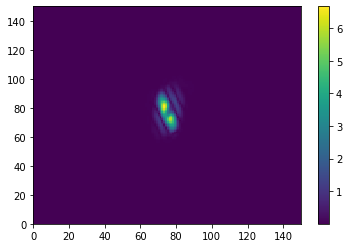

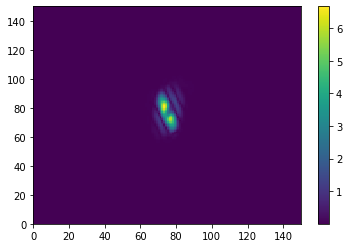

In [318]:
plt.pcolormesh(a1)
plt.colorbar()
plt.show()
plt.pcolormesh(a2)
plt.colorbar()
plt.show()

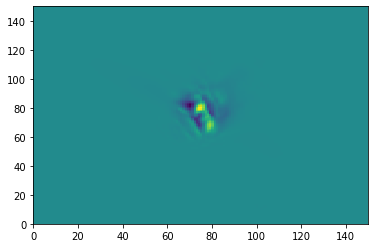

In [251]:
plt.pcolormesh(a1 - a2)
plt.show()

In [103]:
sm.simulations_per_peak[0].nw_rotation_mask_delta_indices.shape, sm.simulations_per_peak[0].nw_rotated_masked_delta_coords.shape

((232998,), (3, 232998))

In [79]:
m._scan_probe_pads

[[[[0, 0], [0, 0], [0, 0]]]]

In [71]:
m.magnitudes_log_v

<tf.Variable 'magnitudes_log_v:0' shape=(95, 147) dtype=float32, numpy=
array([[-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
        -16.118095],
       [-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
        -16.118095],
       [-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
        -16.118095],
       ...,
       [-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
        -16.118095],
       [-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
        -16.118095],
       [-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
        -16.118095]], dtype=float32)>

In [74]:
batch_v = tf.constant([0])

In [52]:
m.variables

{'phases': <tf.Variable 'phases:0' shape=(13965,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 'magnitudes_log_v': <tf.Variable 'magnitudes_log_v:0' shape=(13965,) dtype=float32, numpy=
 array([-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
        -16.118095], dtype=float32)>}

In [36]:
sm.sample.obj_mask_full[:,100,50].sum(), sm.sample.obj_mask_w_delta[:,100,50].sum()

(85, 95)

In [38]:
m._pady0, m._npix_y

(53, 95)

In [26]:
arr = tf.constant([1.0, 2.0])

In [27]:
s1 = np.s_[0:2]

In [29]:
arr[s1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 2.], dtype=float32)>

In [ ]:
class MultiReflectionBraggPtychoFwdModel(abc.ABC):

    @abc.abstractmethod
    def __init__(self, sim: Simulation):
        self._sim = sim
        self.variables = {}

        self._setPixelsAndPads()
        with tf.device('/gpu:0'):
            self._coords_t = tf.constant(self._sim.simulations_per_peak[0].nw_coords_stacked, dtype='float32')
            self._setScanCoords()

            self._setInterpolationLimits()
            self._setProbesAndMasks()
            self._setLocationIndices()
            self._setSliceIndices()

            self._setPhaseDisplacementInversionMatrix()

    def _setScanCoords(self):

        if hasattr(self._sim.simulations_per_peak[0], "ptycho_scan_positions"):
            self._has_scan_coords_per_peak = True
            self._n_positions_per_peak = [s.ptycho_scan_positions.shape[0] for s in self._sim.simulations_per_peak]
            self._cum_positions_per_peak = tf.math.cumsum(self._n_positions_per_peak)
            self._scan_coords_t = tf.constant(np.concatenate([s.ptycho_scan_positions
                                                              for s in self._sim.simulations_per_peak],
                                                             axis=0),
                                              dtype='int32')
        else:
            raise
            self._has_scan_coords_per_peak = False
            self._scan_coords_t = tf.constant(self._sim.ptycho_scan_positions, dtype='int32')


    def _addMagnitudeVariable(self, magnitudes_init=None, magnitude_log_constraint_fn=None):
        if self._shared_magnitudes:
            size = self._npix_xy + self._sim.params.HKL_list.shape[0] - 1
        else:
            size = self._npix_xy * self._sim.params.HKL_list.shape[0]

        if magnitudes_init is None:
            magnitudes_init = np.zeros(size, dtype='float32')
        else:
            if magnitudes_init.size != size:
                raise ValueError("magnitude initialization supplied is not valid")

        magnitudes_init_logs = np.log(magnitudes_init + 1e-7)
        #magnitudes_init_logs = magnitudes_init
        with tf.device('/gpu:0'):
            self.magnitudes_log_v = tf.Variable(magnitudes_init_logs,
                                           constraint=magnitude_log_constraint_fn,
                                           dtype='float32',
                                           name='magnitudes_log_v')
        self.variables['magnitudes_log_v'] =  self.magnitudes_log_v

    def _addDisplacementVariable(self, ux_uy_init=None):
        if ux_uy_init is None:
            ux_uy_init = np.ones(self._npix_xy * 2)
        else:
            if len(ux_uy_init.shape) != 1:
                raise ValueError("Supply a flat 1d array for the initialization.")
        with tf.device('/gpu:0'):
            self.ux_uy_2d_v = tf.Variable(ux_uy_init, dtype='float32', name='ux_uy')
        self.variables['ux_uy_2d_v'] = self.ux_uy_2d_v

    def _addPhaseVariable(self, phases_init=None):

        if phases_init is None:
            phases_init = np.zeros(self._npix_xy * self._sim.params.HKL_list.shape[0])

        with tf.device('/gpu:0'):
            self.phases_v = tf.Variable(phases_init, dtype='float32', name='phases')
        self.variables['phases'] = self.phases_v



    def _setPixelsAndPads(self):
        self._npix_x = np.sum(np.sum(self._sim.sample.obj_mask_w_delta, axis=(0, 2)) > 0)
        self._npix_y = np.sum(np.sum(self._sim.sample.obj_mask_w_delta, axis=(1, 2)) > 0)
        self._npix_z = np.sum(np.sum(self._sim.sample.obj_mask_w_delta, axis=(0, 1)) > 0)

        self._npix_xy = self._npix_x * self._npix_y

        self._nyr, self._nxr, self._nzr = self._sim.rhos[0].shape
        self._pady0 = np.where(self._sim.sample.obj_mask_w_delta.sum(axis=(1, 2)))[0][0]
        self._padx0 = np.where(self._sim.sample.obj_mask_w_delta.sum(axis=(0, 2)))[0][0]
        self._padz0 = np.where(self._sim.sample.obj_mask_w_delta.sum(axis=(0, 1)))[0][0]

    def _setInterpolationLimits(self):
        # These arrays indicate the limits of the interpolation before the bragg projection.
        self._interp_x_ref_min_t = tf.constant([self._sim.sample.y_full[0],
                                                self._sim.sample.x_full[0],
                                                self._sim.sample.z_full[0]], dtype='float32')
        self._interp_x_ref_max_t = tf.constant([self._sim.sample.y_full[-1],
                                                self._sim.sample.x_full[-1],
                                                self._sim.sample.z_full[-1]], dtype='float32')


    def _setProbesAndMasks(self):
        # This is a workaround bc the different arrays for the different siulations might not necessarily
        # have the same number of elements. Tensorflow doesn't handle that well.
        # ------------------------------------------------------------------------------------------------
        # Since I have truncated probe structures for efficiency reasons, they are not of the same 3d shape
        # for the different bragg peaks.
        self.probes_all_t = tf.constant(np.concatenate([s.probe.flatten() for s in
                                                        self._sim.simulations_per_peak]),
                                        dtype='complex64')

        # After rotation (for the final projection), we can speed up the interpolation by only selecting
        # the rotated coordinates that lie within the unrotated object box.
        # The number of coordinates to interpolate can vary per bragg peak.
        self._coords_rotated_masked_t = tf.constant(np.concatenate([s.nw_rotated_masked_coords.T.flatten()
                                                                    for s in self._sim.simulations_per_peak]),
                                                    dtype='float32')
        self._rotation_mask_indices_t = tf.constant(np.concatenate([s.nw_rotation_mask_indices.flatten()
                                                                    for s in self._sim.simulations_per_peak]),
                                                    dtype='int32')

    def _setLocationIndices(self):
        # These contain information about how to select the appropriate probe, etc.
        probes_iloc_all = []
        coords_iloc_all = []
        rotix_iloc_all = []
        for i, sim_per_peak in enumerate(self._sim.simulations_per_peak):
            if i == 0:
                s1 = 0
                s2 = 0
                s3 = 0
            else:
                s1 = probes_iloc_all[i - 1][0] + probes_iloc_all[i - 1][1]
                s2 = coords_iloc_all[i - 1][0] + coords_iloc_all[i - 1][1]
                s3 = rotix_iloc_all[i - 1][0] + rotix_iloc_all[i - 1][1]
            probes_iloc_all.append([s1, sim_per_peak.probe.size, *sim_per_peak.probe.shape])
            coords_iloc_all.append([s2, sim_per_peak.nw_rotated_masked_coords.T.size,
                                    *sim_per_peak.nw_rotated_masked_coords.T.shape])
            rotix_iloc_all.append([s3, sim_per_peak.nw_rotation_mask_indices.size,
                                   *sim_per_peak.nw_rotation_mask_indices.shape])
        self._probes_iloc_t = tf.constant(probes_iloc_all, dtype='int32')
        self._coords_iloc_t = tf.constant(coords_iloc_all, dtype='int32')
        self._rotix_iloc_t = tf.constant(rotix_iloc_all, dtype='int32')

    def _setSliceIndices(self):

        # A lot of this slicing and dicing is aimed at avoiding expensive "roll" operations.
        # I am reusing indices computed during the forward simulation for the recons as well.
        self._scan_rho_slice_indices_t = tf.constant([self._getStartStopIndicesFromSliceList(s.rho_slices)
                                                      for s in self._sim.simulations_per_peak], dtype='int32')
        self._scan_probe_slice_indices_t = tf.constant([self._getStartStopIndicesFromSliceList(s.probe_slices)
                                                        for s in self._sim.simulations_per_peak], dtype='int32')
        self._scan_proj_slice_indices_t = tf.constant([self._getStartStopIndicesFromSliceList(s.proj_slices)
                                                       for s in self._sim.simulations_per_peak], dtype='int32')

    def _setPhaseDisplacementInversionMatrix(self):
        """To solve an overdetermined linear system Ax = b, we can use the relation:
        x = (A^T A)^(-1) A^T b.

        This function calculates and stores the matrix (A^T A)^(-1) A^T  for the unwrapped phases -> displacement
        transformation.
        """
        hkl_matrix = np.array(self._sim.params.HKL_list)[:, :2]  # Ignoring the z components
        inversion_matrix = np.linalg.inv(hkl_matrix.T @ hkl_matrix) @ hkl_matrix.T / (2 * np.pi)
        self._displacement_invert_matrix_t = tf.constant(inversion_matrix, dtype='float32')

    @staticmethod
    def _getStartStopIndicesFromSliceList(slice_list):
        indices_list = []
        for slice_y, slice_x in slice_list:
            sy1 = slice_y.start
            sy2 = slice_y.stop
            sx1 = slice_x.start
            sx2 = slice_x.stop
            indices_list.append([sy1, sy2, sx1, sx2])
        return indices_list

    def getMagnitudes2d(self, magnitudes_log_v):
        if self._shared_magnitudes:
            mags_log_2d_profile = tf.reshape(magnitudes_log_v[:self._npix_xy], (self._npix_y, self._npix_x))
            mags_scaling_vars = magnitudes_log_v[self._npix_xy:]
            mags_scaling_all = tf.concat(([0.0], mags_scaling_vars), axis=0)
            mags_log_2d_all = mags_log_2d_profile + mags_scaling_all[:, None, None]
        else:
            mags_log_2d_all = tf.reshape(magnitudes_log_v, (-1, self._npix_y, self._npix_x))

        magnitudes_2d_all = tf.exp(mags_log_2d_all)
        #magnitudes_2d_all = mags_log_2d_all
        return magnitudes_2d_all

    def getUxUy2d(self, ux_uy_2d_v):
        ux_uy_2d_reshaped_t = tf.reshape(ux_uy_2d_v, (2, self._npix_y, self._npix_x))
        ux_2d_t = ux_uy_2d_reshaped_t[0]
        uy_2d_t = ux_uy_2d_reshaped_t[1]
        return ux_2d_t, uy_2d_t

    def _get2dPhasesFromDisplacements(self, Ux_t, Uy_t):
        phases_all_t = []
        for H, K, L in self._sim.params.HKL_list:
            t1 = H * Ux_t + K * Uy_t #+ L * Uz_t
            phase_t = 2 * np.pi * t1
            phases_all_t.append(phase_t)
        phases_all_t = tf.stack(phases_all_t)
        return phases_all_t

    def get2dPhasesFromDisplacementVars(self):
        ux_2d_t, uy_2d_t = self.getUxUy2d(self.ux_uy_2d_v)
        uz_2d_t = tf.zeros_like(ux_2d_t)
        phases = self._get2dPhasesFromDisplacements(ux_2d_t, uy_2d_t)
        return phases

    def get2dRhoFromDisplacements(self, Ux_t, Uy_t, magnitudes_2d_t):
        """Calculate the magnitude and phase profile using the provided magnitudes and HKL list.

        Sets the rhos for the sample class, and also returns the rhos.

        Assumes that the displacements are normalized w.r.t. to the lattice constant, i.e.
        Ux_t = Ux_t_actual / lattice[0]
        Uy_t = Uy_t_actual / lattice[1]
        Uz_t = Uz_t actual / lattice[2]

        Parameters
        ----------
        ...
        Returns
        -------
        """

        phases_all_t = self._get2dPhasesFromDisplacements(Ux_t, Uy_t)
        rhos_all_t = tf.complex(magnitudes_2d_t * tf.cos(phases_all_t),
                                magnitudes_2d_t * tf.sin(phases_all_t))
        return rhos_all_t

    def get3dRhoFromDisplacements(self, ux_uy_2d_v, magnitudes_log_v):
        magnitudes_2d_all_t = self.getMagnitudes2d(magnitudes_log_v)

        ux_2d_t, uy_2d_t = self.getUxUy2d(ux_uy_2d_v)
        #uz_2d_t = tf.zeros_like(ux_2d_t)

        rho_2d_cmplx_all_t = self.get2dRhoFromDisplacements(ux_2d_t, uy_2d_t, magnitudes_2d_all_t)
        rho_3d_all_t = tf.ones(self._npix_z, dtype='complex64')[None, None, None, :] * rho_2d_cmplx_all_t[:, :, :, None]
        rho_3d_bordered_all_t = tf.pad(rho_3d_all_t, [[0, 0],
                                                      [self._pady0, self._nyr - self._pady0 - self._npix_y],
                                                      [self._padx0, self._nxr - self._padx0 - self._npix_x],
                                                      [self._padz0, self._nzr - self._padz0 - self._npix_z]])
        return rho_3d_bordered_all_t

    def get2dRhoFromPhases(self, phases_v, magnitudes_log_v):
        magnitudes_2d_all_t = self.getMagnitudes2d(magnitudes_log_v)
        phases_2d_t = tf.reshape(phases_v, [-1, self._npix_y, self._npix_x])
        rho_2d_cmplx_all_t = tf.complex(magnitudes_2d_all_t * tf.math.cos(phases_2d_t),
                                        magnitudes_2d_all_t * tf.math.sin(phases_2d_t))
        return rho_2d_cmplx_all_t

    def get3dRhoFromPhases(self, phases_v, magnitudes_log_v):
        rho_2d_cmplx_all_t = self.get2dRhoFromPhases(phases_v, magnitudes_log_v)
        rho_3d_all_t = tf.ones(self._npix_z, dtype='complex64')[None, None, None, :] * rho_2d_cmplx_all_t[:, :, :, None]
        rho_3d_bordered_all_t = tf.pad(rho_3d_all_t, [[0, 0],
                                                      [self._pady0, self._nyr - self._pady0 - self._npix_y],
                                                      [self._padx0, self._nxr - self._padx0 - self._npix_x],
                                                      [self._padz0, self._nzr - self._padz0 - self._npix_z]])
        return rho_3d_bordered_all_t



    def _getProjFtT(self, rho_3d_bordered_all_t, scan_index):
        """Output the projected diffraction pattern at the input scan index.

        Parameters
        ----------
        scan_index_t : tensor(int)
            This indicates the location of the selected diffraction pattern in the overall
            large array containing all the diffraction patterns, for all the bragg peaks.
        Returns
        -------
        out_t : tensor(float32)
            This is the predicted diffraction pattern.
        """
        #

        # Identifying the appropriate bragg peak and ptychographic scan position for the given
        # scan index
        if self._has_scan_coords_per_peak:
            bragg_index = tf.searchsorted(self._cum_positions_per_peak,
                                          [tf.cast(scan_index, tf.int32)], side='right')[0]
            scan_coord_index = scan_index % self._n_positions_per_peak[0]
        else:
            bragg_index = scan_index // len(self._sim.ptycho_scan_positions)
            scan_coord_index = scan_index % len(self._sim.ptycho_scan_positions)
        scan_coord_t = self._scan_coords_t[scan_coord_index]

        # the y and x positions for the scan
        pcy = scan_coord_t[0]
        pcx = scan_coord_t[1]

        # again, a lot the the slicing and dicing
        rho_slice = self._scan_rho_slice_indices_t[bragg_index, scan_coord_index]
        proj_slice = self._scan_proj_slice_indices_t[bragg_index, scan_coord_index]
        probe_slice = self._scan_probe_slice_indices_t[bragg_index, scan_coord_index]

        iloc1 = self._probes_iloc_t[bragg_index]
        # Slicing and reshaping to get the probe
        probe_this = tf.reshape(self.probes_all_t[iloc1[0]: iloc1[0] + iloc1[1]], iloc1[2:])

        iloc2 = self._coords_iloc_t[bragg_index]
        # getting the coordinates that we want to interpolate at.
        coords_rotated_masked_this = tf.reshape(self._coords_rotated_masked_t[iloc2[0]: iloc2[0] + iloc2[1]],
                                                iloc2[2:])

        iloc3 = self._rotix_iloc_t[bragg_index]
        rotation_mask_indices_this = tf.reshape(self._rotation_mask_indices_t[iloc3[0]: iloc3[0] + iloc3[1]],
                                                iloc3[2:])[:, None]

        # Getting the slice of the object numerical window that the probe interacts with and calculating
        # the interaction.
        rho_this = rho_3d_bordered_all_t[bragg_index]
        field_view_t = (rho_this[rho_slice[0]: rho_slice[1], rho_slice[2]:rho_slice[3]]
                        * probe_this[probe_slice[0]: probe_slice[1], probe_slice[2]: probe_slice[3]])

        # setting the field everywhere else to 0.
        field_view_padded_t = tf.pad(field_view_t, [[rho_slice[0], 200 - rho_slice[1]],
                                                    [rho_slice[2], 200 - rho_slice[3]],
                                                    [0, 0]],
                                     mode='constant')

        # iinterpolation for the rotated coordinates that lie within the unrotated object.
        rot_field_reals_t = tfp.math.batch_interp_regular_nd_grid(x=coords_rotated_masked_this,
                                                                  x_ref_min=self._interp_x_ref_min_t,
                                                                  x_ref_max=self._interp_x_ref_max_t,
                                                                  y_ref=tf.math.real(field_view_padded_t),
                                                                  axis=0, fill_value=0)
        rot_field_imag_t = tfp.math.batch_interp_regular_nd_grid(x=coords_rotated_masked_this,
                                                                 x_ref_min=self._interp_x_ref_min_t,
                                                                 x_ref_max=self._interp_x_ref_max_t,
                                                                 y_ref=tf.math.imag(field_view_padded_t),
                                                                 axis=0, fill_value=0)

        # since we only interpolate a small selection of the rotated coordinates, we need to
        # fill the rest of the coordinates with 0.
        field_rotated_real_t = tf.scatter_nd(indices=rotation_mask_indices_this,
                                             updates=tf.reshape(rot_field_reals_t, [-1]),
                                             shape=[tf.size(rho_this)])  # field_this.size])
        field_rotated_imag_t = tf.scatter_nd(indices=rotation_mask_indices_this,
                                             updates=tf.reshape(rot_field_imag_t, [-1]),
                                             shape=[tf.size(rho_this)])  # field_this.size])
        field_rotated_t = tf.complex(field_rotated_real_t, field_rotated_imag_t)

        field_rotated_t = tf.reshape(field_rotated_t, tf.shape(rho_this))

        # Project along the (rotated) z direction to get the exit wave.
        projection_t = tf.reduce_sum(field_rotated_t, axis=2)
        projection_t = projection_t[proj_slice[0]:proj_slice[1], proj_slice[2]:proj_slice[3]]
        proj_ft_t = tf.signal.fft2d(projection_t)
        out_t = tf.abs(proj_ft_t)
        return out_t

    @abc.abstractmethod
    def predict(self, batch_input_v, *vars):
        pass

    def _getMagnitudeNumpyOutput(self):
        magnitudes_2d_all_t = self.getMagnitudes2d(self.magnitudes_log_v)
        outs = {'magnitudes': magnitudes_2d_all_t.numpy()}
        return outs

    def _getDisplacementNumpyOutput(self):
        outs = {}
        ux_2d_t, uy_2d_t = self.getUxUy2d(self.ux_uy_2d_v)
        magnitudes_2d_all_t = self.getMagnitudes2d(self.magnitudes_log_v)
        uz_2d_t = tf.zeros_like(ux_2d_t)

        outs['ux'] = ux_2d_t.numpy()
        outs['uy'] = uy_2d_t.numpy()

        rho_2d_cmplx_all_t = self.get2dRhoFromDisplacements(ux_2d_t,
                                                            uy_2d_t,
                                                            magnitudes_2d_all_t)
        outs['rho_2d'] = rho_2d_cmplx_all_t.numpy()
        return outs

    def _getPhaseNumpyOutput(self):
        outs = {}
        rho_2d_cmplx_all_t = self.get2dRhoFromPhases(self.phases_v, self.magnitudes_log_v)
        outs['rho_2d'] = rho_2d_cmplx_all_t.numpy()
        return outs

    @abc.abstractmethod
    def getNumpyOutputs(self):
        pass